# Graded Challenge 7

## Perkenalan

Nama : Saepul Hilal

Batch : FTDS - 010

Dataset : https://www.kaggle.com/datasets/nafin59/monkeypox-skin-lesion-dataset

Deploy : https://huggingface.co/spaces/saepulhilal/gc7

Objective : Program ini dibuat untuk mendeteksi penyakit monkeypox. Input pada program ini berupa gambar, gambar tersebut akan di prediksi dengan deep learning untuk mengetahui hasil dari gambar tersebut adalah terkena monkeypox atau bukan.

## Import Libraries

In [2]:
import opendatasets as od
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from jmd_imagescraper.core import *
import numpy as np
import random
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetV2B0, MobileNetV2
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
from tqdm import tqdm

## Data Loading

### Download Data

In [3]:
od.download('https://www.kaggle.com/datasets/nafin59/monkeypox-skin-lesion-dataset/data?select=Fold1')

Skipping, found downloaded files in "./monkeypox-skin-lesion-dataset" (use force=True to force download)


### Mengakses File Path

In [4]:
monkeypox_file_train = glob.glob("monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Train/Monkeypox/*")
others_file_train = glob.glob("monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Train/Others/*")
monkeypox_file_val = glob.glob("monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/*")
others_file_val = glob.glob("monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Others/*")

In [5]:
print(f"Total data train : {len(monkeypox_file_train) + len(others_file_train)}")
print(f"Total data Validasi :{len(monkeypox_file_val) + len(others_file_val)}")

Total data train : 2142
Total data Validasi :420


## EDA

### Menampilkan Gambar

In [6]:
# Membuat fungsi untuk menampilkan gambar
def show(name):
    fig,ax = plt.subplots(ncols=10,figsize=(30,3))
    for i,val in enumerate(random.sample(range(0,980),10)):
        cal = plt.imread(name[val])
        ax[i].imshow(cal)

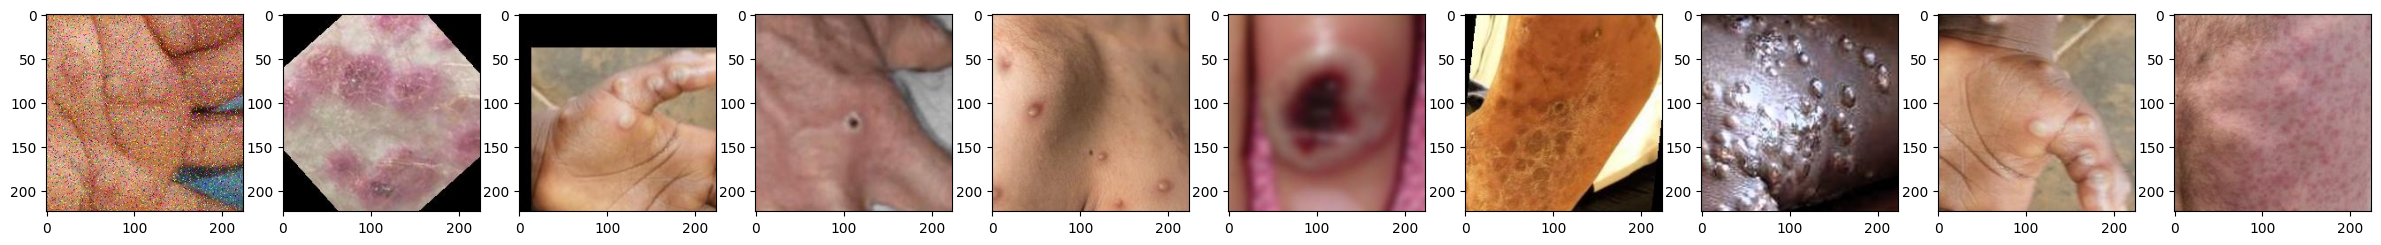

In [7]:
show(monkeypox_file_train) #Menampilkan gambar Monkeypox

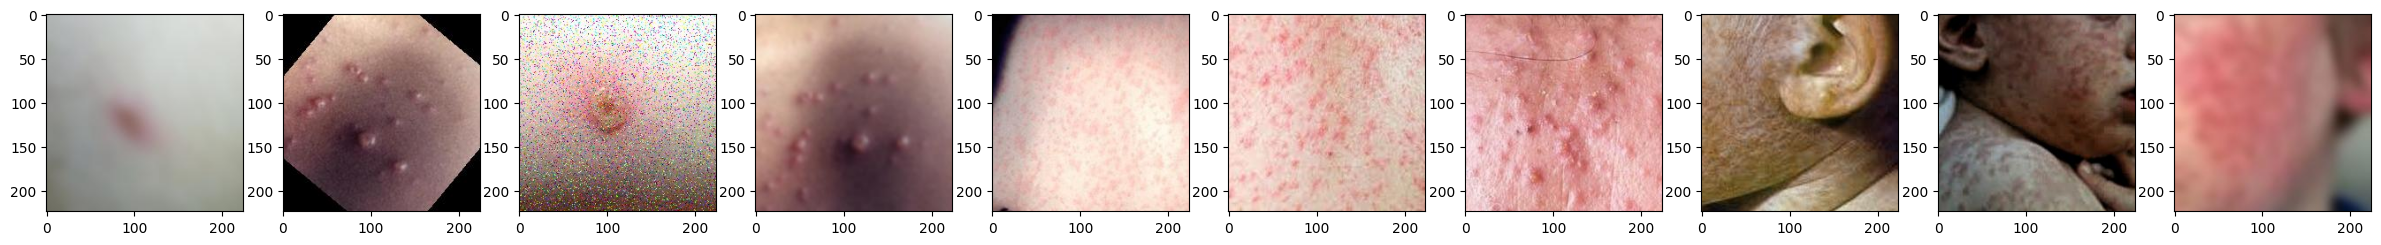

In [8]:
show(others_file_train) # Menampilkan gambar Others

Dari beberapa gambar yang di tampilkan peneliti mendapatkan behavior bahwa gambar diatas sudah melakukan proses data augmentasi, dan ukuran dari setiap gambar adalah 244x244. Untuk mengetahui ukuran keseluruhan gambar peneliti akan membuat fungsi tersendiri

### Mengetahui ukuran gambar

In [9]:
# Membuat fungsi untuk mendapatkan ukuran dari setiap gambar
def size(name):
    width = []
    height = []
    for i in name:
        p = Image.open(i)
        print(p)
        


In [10]:
# Menampilkan Informasi gambar
size(monkeypox_file_train)
size(others_file_train)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x297737050>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x29991C390>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x2977D8610>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x29991C390>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x299977FD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x297737050>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x299923910>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x29985E950>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x299977FD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x297A68810>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x2977D8610>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x299976C50>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB si

Dari informasi diatas dapat diketahui bahwa seluruh gambar memiliki panjang dan lebar yang sama yaitu 244. Sehingga peneliti mengambil keputusan untuk tidak melakukan resizing untuk gambar ini.

## Data Augmentaion

Pada bagian EDA peneliti sudah mengetahui bahwa gambar yang akan diolah telah dilakukan proses Augmentasi. Namun peneliti akan tetap menambahkan parameter zoom pada dataset ini. Alasan menambahkan parameter karena dataset ini belum dilakukan proses tersebut dan agar model dapat belajar lebih dalam lagi apabila gambar tersebut berfariasi. Peneliti juga melakukan rescale untuk mengubah pixel value menjadi range 0-1. Dan pada data set ini telah disediakan file train, validasi, dan test sehingga peneliti tidak perlu melakukan data split. Pada kasus ini adalah Binary maka pada parameter class_mode akan diisi dengan 'binary'

In [11]:
imgen_train_model_1= tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255., # Rescale pixel value
                                                       zoom_range=[0.3, 1.5] # Zooming image
                                                       )
imgen_val_model_1= tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255., # Rescale pixel value
                                                       zoom_range=[0.3, 1.5] # Zooming image
                                                       )

path_train = 'monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Train'
train_data = imgen_train_model_1.flow_from_directory(path_train,
                                  target_size=(224,224),
                                  class_mode='binary',
                                  subset='training',shuffle=False)

path_val = 'monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/'
val_data = imgen_val_model_1.flow_from_directory(path_val,
                                  target_size=(224,224),
                                  class_mode='binary',
                                  shuffle=False)

Found 2142 images belonging to 2 classes.
Found 420 images belonging to 2 classes.


### Menampilkan class untuk file train dan file validasi

In [12]:
print(train_data.class_indices)
print(val_data.class_indices)

{'Monkeypox': 0, 'Others': 1}
{'Monkeypox': 0, 'Others': 1}


### Menampilkan gambar yang sudah dilakukan data augmentasi

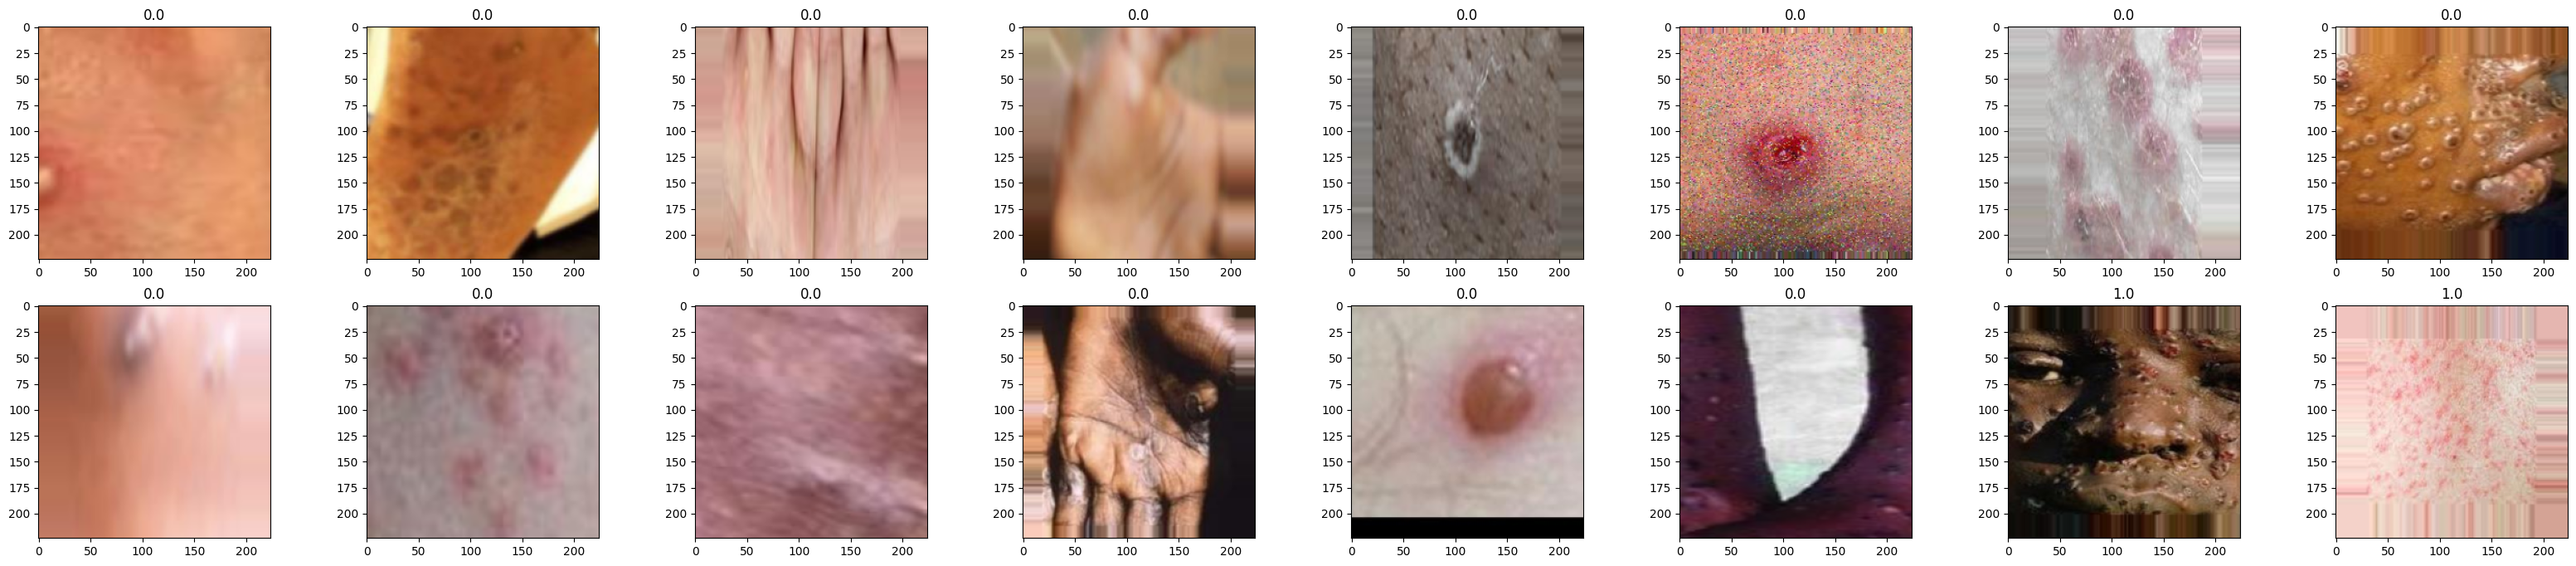

In [13]:
fig,ax = plt.subplots(nrows=2,ncols=8,figsize=(40,8))
n = 0
idx = np.random.randint(len(train_data.next()[0]), size=16)
for i in range(2):
  for j in range(8):
    img = train_data.next()[0][idx[n]]
    ax[i][j].imshow(img)
    ax[i][j].set_title(train_data.next()[1][idx[n]])
    n+=1

## Modeling

Pada tahap ini akan dilakukan dua kali pemodelan. Untuk model pertama akan dilakukan CNN dan unutk model kedua akan dilakukan modeling dengan transfer learning EfficientNetV2B0

### Model 1



#### Arsitektur Model

In [14]:
model_1 = tf.keras.models.Sequential()

### 1st conv layer
model_1.add(tf.keras.layers.Conv2D(32,(3,3), activation='relu', input_shape = (224,224,3)) )
model_1.add(tf.keras.layers.MaxPool2D((2,2), strides=(2, 2)))
#tf.keras.layers.Dropout(0.2),
#tf.keras.layers.BatchNormalization(),

## 2nd conv layer
model_1.add(tf.keras.layers.Conv2D(64,(3,3), activation='relu'))
model_1.add(tf.keras.layers.MaxPool2D((2,2), strides=(2, 2)))
#tf.keras.layers.Dropout(0.1),
#tf.keras.layers.BatchNormalization(),


### 4th conv layer
model_1.add(tf.keras.layers.Conv2D(128,(2,2), activation='relu'))
model_1.add(tf.keras.layers.MaxPool2D((2,2), strides=(2, 2)))
#tf.keras.layers.BatchNormalization(),
    
    
### 5th conv layer
model_1.add(tf.keras.layers.Conv2D(512,(2,2), activation='relu'))
model_1.add(tf.keras.layers.MaxPool2D((2,2), strides=(2, 2)))
# model_1.add(tf.keras.layers.BatchNormalization())

### flatten output and feed it into dense layer
model_1.add(tf.keras.layers.Flatten())
model_1.add(tf.keras.layers.Dense(32, activation='relu'))

## output layer
model_1.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Compile
model_1.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
model_1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 53, 53, 128)       32896     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

#### Gambar dari arsitektur model

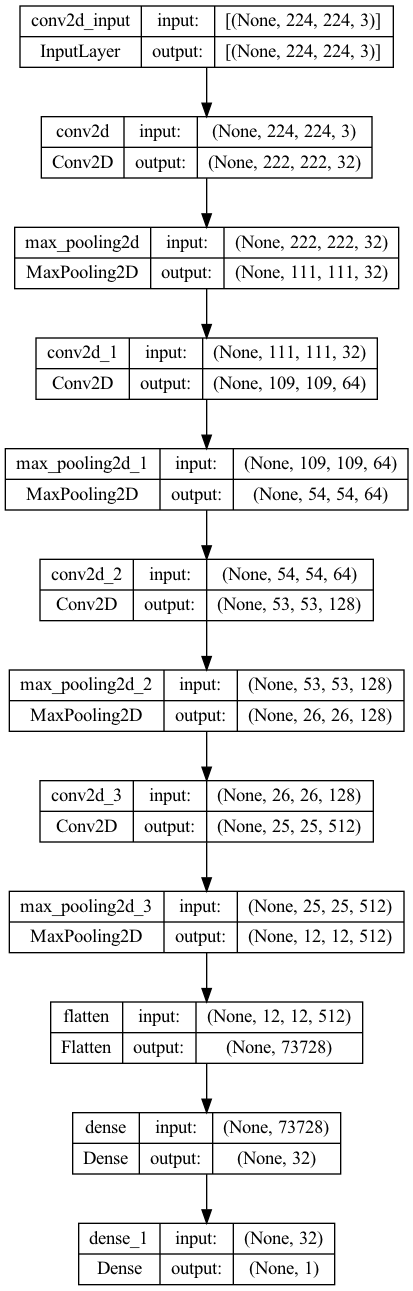

In [15]:
tf.keras.utils.plot_model(model_1, show_shapes=True)

insight : Gambar diatas merupakan urutan langkah-langkah yang digunakan untuk mengolah gambar. Pertama, gambar dioperasikan melalui layer Conv2D untuk mengekstraksi fitur. Kemudian, hasilnya melewati layer MaxPooling2D untuk menyederhanakan informasi. Proses ini diulang beberapa kali dengan filter yang berbeda.

Setelah itu, ada layer Flatten yang meratakan hasilnya menjadi satu baris panjang. Hasil rata tersebut kemudian masuk ke layer Dense dengan 32 "neuron" atau unit pemrosesan informasi. Akhirnya, output dari layer Dense ini melewati satu neuron terakhir untuk memberikan hasil akhir.

Totalnya, model ini memiliki sekitar 2,7 juta parameter yang dapat disesuaikan selama pelatihan. Semua parameter ini dapat disesuaikan atau "dilatih" untuk memahami pola dan fitur dalam data gambar yang digunakan.

### Membuat Callbacks

In [16]:
callbacks1= [
    EarlyStopping(monitor='val_loss', patience= 3, restore_best_weights=True),
    ModelCheckpoint('model_best.hdf5', monitor='val_loss', save_best_only=True)
]

### Model 1 Training

In [17]:
# Train the Model
history_model_1 = model_1.fit(train_data,epochs=30, steps_per_epoch=20,validation_data=val_data,verbose=1,validation_steps=10,callbacks=callbacks1)

Epoch 1/30
20/20 [==============================] - 15s 733ms/step - loss: 0.8117 - accuracy: 0.5016 - val_loss: 0.6952 - val_accuracy: 0.4750
Epoch 2/30


/Applications/miniconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 14s 673ms/step - loss: 0.6743 - accuracy: 0.6500 - val_loss: 0.6955 - val_accuracy: 0.4750
Epoch 3/30
20/20 [==============================] - 15s 744ms/step - loss: 0.6980 - accuracy: 0.5000 - val_loss: 0.6939 - val_accuracy: 0.4750
Epoch 4/30
20/20 [==============================] - 14s 715ms/step - loss: 0.6893 - accuracy: 0.6000 - val_loss: 0.6933 - val_accuracy: 0.4750
Epoch 5/30
20/20 [==============================] - 16s 809ms/step - loss: 0.6696 - accuracy: 0.6500 - val_loss: 0.7155 - val_accuracy: 0.4750
Epoch 6/30
20/20 [==============================] - 15s 745ms/step - loss: 0.7173 - accuracy: 0.5987 - val_loss: 0.6966 - val_accuracy: 0.4750
Epoch 7/30
20/20 [==============================] - 16s 815ms/step - loss: 0.6924 - accuracy: 0.5688 - val_loss: 0.6935 - val_accuracy: 0.4750


### Monitoring Training

Pada tahap ini akan menampilkan 2 lineplot mengenai loss dan acuracy. Monitoring ini dilakukan untuk mempermudah melihat hasil dari training

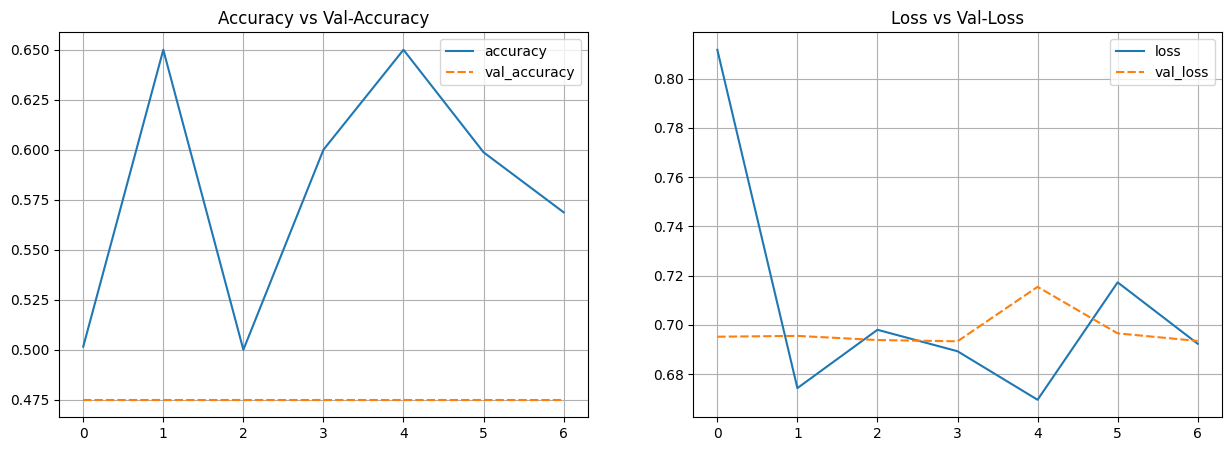

In [18]:
# Plot Training Results

history_model_1 = pd.DataFrame(history_model_1.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_model_1[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_model_1[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.show()

Dapat dilihat dari visual diatas bahwa pemodelan pertama memiliki hasil yang kurang bagus. Pada data validasi mendapatkan akurasi sebesar 0.4750 dan untuk loss sebesar 0.6935. Dari nilai akurasi yang dibawah 0,5 dan pada visual juga terdapat exploding maka disimpulkan pemodelan pertama kurang memuaskan

### Model 2

pada tahap ini adalah model improve dari pemodelan pertama dengan menggunaka transfer learning

#### Preprose Untuk model 2

In [19]:
imgen_train= tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=[0.3, 1.5])
imgen_val= tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=[0.3, 1.5])


path_train = 'monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Train'
train_data_model2 = imgen_train.flow_from_directory(path_train,
                                  target_size=(224,224),
                                  class_mode='binary',
                                  subset='training',shuffle=False)

path_val = 'monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/'
val_data_model2 = imgen_val.flow_from_directory(path_val,
                                  target_size=(224,224),
                                  class_mode='binary',
                                  shuffle=False)

Found 2142 images belonging to 2 classes.
Found 420 images belonging to 2 classes.


In [20]:
eff = EfficientNetV2B0(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3),
    classifier_activation='sigmoid'
)
eff.trainable=False
# for layer in eff.layers[:-10]:
#     layer.trainable = False

train_new = tf.keras.applications.efficientnet.preprocess_input(train_data_model2)
val_new = tf.keras.applications.efficientnet.preprocess_input(val_data_model2)

#### Arsitektur Model 2

In [21]:
seed=20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# Tambahkan lapisan-lapisan yang Anda definisikan sebelumnya setelah VGG16
model_2 = Sequential()
model_2.add(eff)
## flatten output and feed it into dense layer
model_2.add(tf.keras.layers.Flatten())
model_2.add(tf.keras.layers.Dense(512, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal(seed)))
model_2.add(Dropout(0.1, seed=seed))
model_2.add(tf.keras.layers.Dense(128, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal(seed)))
model_2.add(Dropout(0.1, seed=seed))
model_2.add(tf.keras.layers.Dense(64, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal(seed)))
model_2.add(Dropout(0.1, seed=seed))
model_2.add(tf.keras.layers.Dense(32, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal(seed)))
model_2.add(Dropout(0.1, seed=seed))
model_2.add(tf.keras.layers.Dense(32, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal(seed)))
model_2.add(Dropout(0.1, seed=seed))

## output layer
model_2.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Compile
model_2.compile(loss='binary_crossentropy',
                optimizer='adaMax',
                metrics=['accuracy'])
model_2.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Functio  (None, 7, 7, 1280)        5919312   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 512)               32113152  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

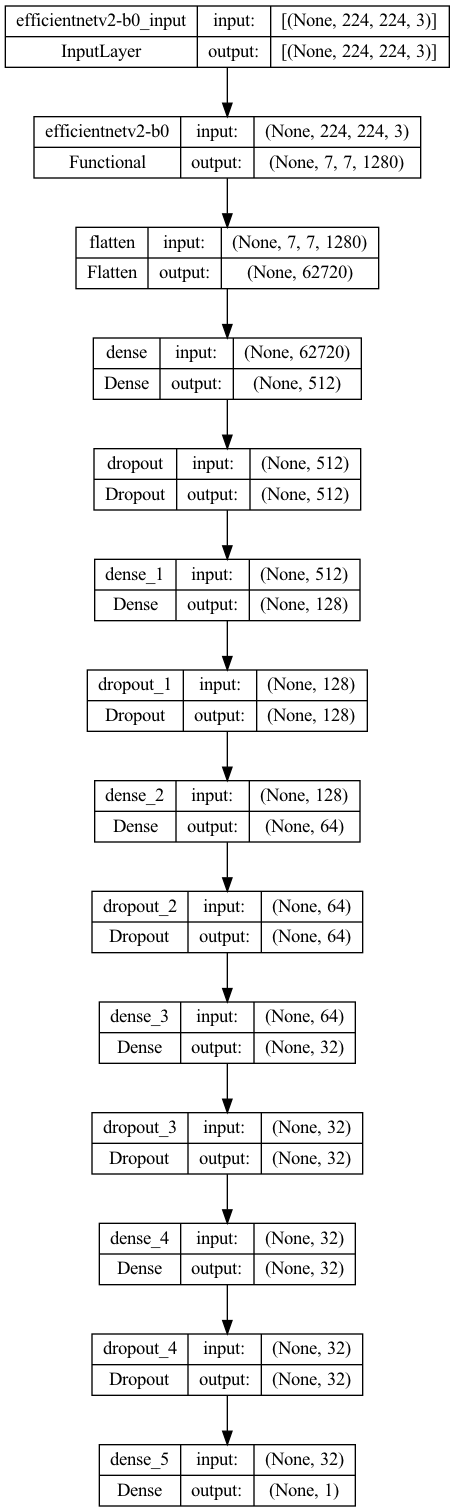

In [22]:
tf.keras.utils.plot_model(model_2, show_shapes=True)

Insight :Gambar diatas adalah arsitektur model dengan tipe Sequential yang terdiri dari beberapa langkah pengolahan. Pertama, ada langkah yang menggunakan efficientnetv2-b0 untuk mengubah gambar menjadi matriks dengan ukuran 7x7x1280. Selanjutnya, matriks ini diubah menjadi vektor satu dimensi dengan panjang 62720.

Kemudian, vektor tersebut melewati langkah-langkah untuk memproses informasi. Langkah pertama adalah lapisan Dense dengan 512 "pemrosesan" neuron dan dilanjutkan dengan langkah Dropout untuk mencegah informasi yang terlalu spesifik. Proses ini diulangi beberapa kali, mengurangi jumlah neuron menjadi 128, 64, dan 32, dengan Dropout setiap langkahnya.

Akhirnya, ada lapisan Dense terakhir dengan satu neuron yang menghasilkan output akhir. Jumlah total parameter model ini adalah 38.109.553, di mana 32.190.241 di antaranya dapat diubah atau "dilatih" selama pelatihan model. Ada juga 5.919.312 parameter yang tidak dapat diubah.

In [23]:
callbacks2= [
    EarlyStopping(monitor='val_loss', patience= 3, restore_best_weights=True),
    ModelCheckpoint('model_best_2.hdf5', monitor='val_loss', save_best_only=True)
]

In [24]:
history_model_2 = model_2.fit(train_new, 
                              epochs= 30,steps_per_epoch= 20, 
                              validation_data=val_new,
                              verbose=1, 
                              callbacks= callbacks2)

Epoch 1/30
20/20 [==============================] - ETA: 0s - loss: 2.9073 - accuracy: 0.6234

/Applications/miniconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 20s 864ms/step - loss: 2.9073 - accuracy: 0.6234 - val_loss: 1.1243 - val_accuracy: 0.6238
Epoch 2/30
20/20 [==============================] - 14s 716ms/step - loss: 1.1334 - accuracy: 0.5938 - val_loss: 0.6414 - val_accuracy: 0.6643
Epoch 3/30
20/20 [==============================] - 13s 670ms/step - loss: 1.1128 - accuracy: 0.5781 - val_loss: 0.7696 - val_accuracy: 0.6381
Epoch 4/30
20/20 [==============================] - 14s 709ms/step - loss: 0.8057 - accuracy: 0.6223 - val_loss: 0.6597 - val_accuracy: 0.6119
Epoch 5/30
20/20 [==============================] - 14s 674ms/step - loss: 0.7497 - accuracy: 0.6531 - val_loss: 0.6921 - val_accuracy: 0.6905


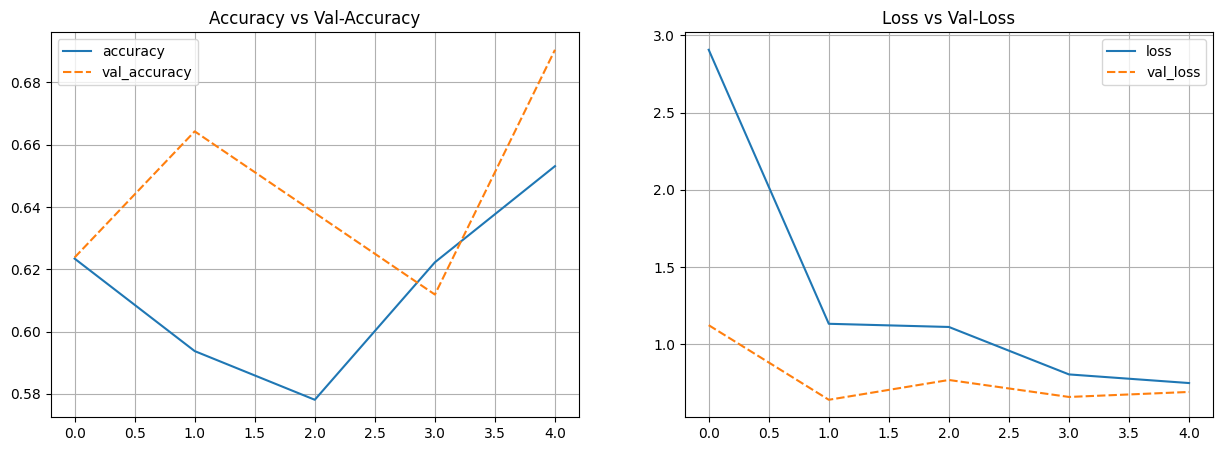

In [25]:
# Plot Training Results

history_model_2 = pd.DataFrame(history_model_2.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_model_2[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_model_2[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.show()

Dapat dilihat dari visual diatas bahwa pemodelan kedua memiliki hasil yang lebih bagus dari pemodelan pertama. Pada data validasi mendapatkan akurasi sebesar 0.6905 dan untuk loss sebesar 0.6921. Namun masih terlihat dari visual terdapat exploding data. Namun setidaknya model ini lebih baik dari pada model pertama maka model ini akan dijadikan modeling untuk kasus ini

## Model Evaluasi

In [27]:
imgen_test= tf.keras.preprocessing.image.ImageDataGenerator()


path_test = 'monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Test'
test_data = imgen_train.flow_from_directory(path_test,
                                  target_size=(224,224),
                                  class_mode='binary',shuffle=False)


Found 45 images belonging to 2 classes.


### Evaluate Model

In [28]:

test_loss_eff, test_acc_eff = model_2.evaluate(test_data, verbose=2)
print('\nVal accuracy (EfficientNetV2B0):', test_acc_eff)
print('Val loss (EfficientNetV2B0):', test_loss_eff) 

2/2 - 1s - loss: 0.5108 - accuracy: 0.8000 - 674ms/epoch - 337ms/step

Val accuracy (EfficientNetV2B0): 0.800000011920929
Val loss (EfficientNetV2B0): 0.5107685327529907


Insight : Pada epoch kedua dari dua total epoch yang dijalankan, diperoleh hasil pelatihan dengan nilai loss sebesar 0.5108 dan akurasi sebesar 80%. Proses pelatihan ini memakan waktu sekitar 1 detik per epoch, dengan setiap langkah pelatihan memakan waktu sekitar 674 milidetik. Selanjutnya, dilakukan evaluasi pada model EfficientNetV2B0 pada data validasi, menghasilkan akurasi sebesar 80% dan nilai loss sebesar 0.5108.

2/2 [==============================] - 1s 136ms/step
              precision    recall  f1-score   support

   Monkeypox       0.58      0.90      0.71        20
      Others       0.86      0.48      0.62        25

    accuracy                           0.67        45
   macro avg       0.72      0.69      0.66        45
weighted avg       0.73      0.67      0.66        45



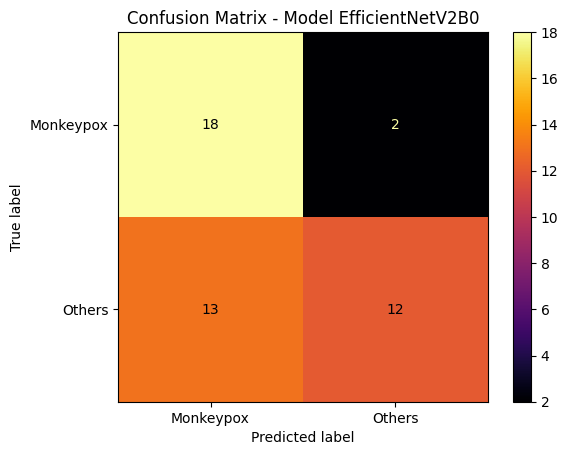

In [40]:
# Memprediksi menggunakan model ResNet
y_pred_test_eff = model_2.predict(test_data)

# Mengonversi probabilitas ke label kelas
y_pred_test_eff = (y_pred_test_eff > 0.698).astype(int)

# Classification Report dan Confusion Matrix untuk Model EfficientNetV2B0
announce_resnet = classification_report(test_data.labels,
                                        y_pred_test_eff, labels=np.arange(2),
                                        target_names=list(test_data.class_indices.keys()))
print(announce_resnet)

conf_matrix_eff = confusion_matrix(test_data.labels, y_pred_test_eff)
disp_eff = ConfusionMatrixDisplay(conf_matrix_eff, display_labels=list(test_data.class_indices.keys()))
disp_eff.plot(cmap='inferno', values_format='d')
plt.title('Confusion Matrix - Model EfficientNetV2B0')
plt.show()


Insight : 

Fokus pada evaluasi adalah pada nilai recall yang ada di monkeypox. Hasil evaluasi model menunjukkan bahwa untuk mengidentifikasi kasus Monkeypox, model memiliki tingkat keakuratan sebesar 67%. Dalam hal ini, ketepatan (precision) untuk Monkeypox adalah 58%, yang berarti dari kasus yang diprediksi sebagai Monkeypox, 58% benar-benar merupakan Monkeypox. Kemudian, recall atau ketepatan deteksi sebesar 90%, menunjukkan bahwa dari seluruh kasus Monkeypox yang ada, model berhasil mendeteksi 90% di antaranya.

Sementara itu, untuk kategori lainnya (Others), tingkat keakuratan model adalah 48%, dengan precision sebesar 86% (dari kasus yang diprediksi sebagai Others, 86% benar-benar Others) dan recall sebesar 48% (dari seluruh kasus Others yang ada, model hanya berhasil mendeteksi 48%).

Secara keseluruhan, model memiliki tingkat keakuratan rata-rata (accuracy) sebesar 67%, dengan f1-score sebesar 0.66. F1-score adalah metrik yang mencakup kedua precision dan recall, dan semakin tinggi nilainya, semakin baik performa modelnya. Meskipun ada ruang untuk perbaikan, hasil ini memberikan gambaran tentang seberapa baik model dapat mengidentifikasi Monkeypox dan kategori lainnya.

## Model Saving

In [30]:
model_2.save('model2.keras')

## Kesimpulan

1. **Jumlah Data:** Terdapat total 2142 data train dan 420 data validasi untuk pelatihan model.

2. **Arsitektur Model:**
   - Menggunakan model Sequential dengan base EfficientNetV2B0.
   - Total parameter model sebanyak 38,109,553, dengan 32,190,241 parameter yang dapat di-train.
   - Dilakukan beberapa lapisan Dense dengan dropout untuk menghindari overfitting.

3. **Pelatihan Model:**
   - Model dilatih selama 30 epoch.
   - Hasil dari Training pada data validasi mendapatkan akurasi sebesar 0.6905 dan untuk loss sebesar 0.6921

4. **Hasil Evaluasi:**
   - Setelah pelatihan, model berhasil mencapai akurasi validasi sebesar 80%.
   - Hasil evaluasi pada data uji menunjukkan bahwa model memiliki performa baik dalam mendeteksi Monkeypox (precision 58%, recall 90%) namun kurang baik dalam mendeteksi kategori lain (precision 86%, recall 48%).
   - Akurasi keseluruhan pada data uji adalah 67%, dengan nilai f1-score sebesar 0.66.

Model berhasil mencapai akurasi yang baik pada data validasi, terutama dalam mengenali Monkeypox. Namun, masih diperlukan perbaikan khususnya dalam meningkatkan recall untuk kategori lainnya agar hasil evaluasi lebih seimbang. Rekomendasi penggunaan format penyimpanan model yang lebih baru juga perlu dipertimbangkan.